# Multi Model Utilization for Time Series Prediction (SPY)

Description of Data
1. SPY - SPDR S&P 500 
2. VIX - Market Volatility
3. SPX 1M 25DP - Implied Volatility of SPX 25Delta Puts
4. SPX 1M 25DC - Implied Volatiity of SPX 25Delta Calls
5. SPX 1M 100% Moneyness Implied Voltility
6. P/C Ratio - Put Call Ratio (25DP/25DC)
7. P/C Spread - Put Call Spread (25DP - 25DC)
8. P/ATM Ratio - Put At The Money Ratio (25DP/SPX1M100Vol)
9. P/ATM Spread - Put At The Money Spread (25DP - SPX1M100Vol)
10. ATM/C Ratio - At The Money Call Ratio (SPX1M100Vol / 25DC)
11. ATM/C Spread - Ath The Money Call Spread (SPX1M100Vol - 25DC)

Note: On Option Data: Skew measures the relative cost between a downside put and upside call of an option
a. If skew increases, puts have become more expensive vs. calls, indicating a bearish  sentiment shift
b. If skew decreases, puts have become less expensive vs. calls, indicating a bullish sentiment shift

12. FICC Spread - Measures Option Adjusted Spreads on High Yield US Corporate Debt
13. TEDSPREAD - Difference between 3M LIBOR and T-Bills / Indicator of Credit Risk
14. Gold Close - Daily Prices of Gold Close
15. Delta10Y/2Y - Ratio of the 10Y T-Notes over the 2Y Tbills
16. 10Y Yield - Yield on the 10Y Treasury.
17. Delta 10Y/3M - Ratio of the 10Y Treasury over the 3M Treasury
Note: As TED Spread Increases, sign that lenders beleive the risk of default is increasing.

Date sourced from Bloomberg, FRED Database, and YFinance

In [1]:
from pathlib import Path
import pandas as pd
filepath=('TheData.csv')
model_df = pd.read_csv(filepath)
model_df.head()
model_df.set_index(("Date"), inplace=True)
model_df.drop(columns=['Daily Returns', 'Cumulative Returns'], inplace=True)
data = model_df
# Daily and Cumulative Returns Not Necessary Columns
data.head(1)

,SPY Close,VIX Close,SPX 1M 25DP Vol BVOL INDEX,SPX 1M 25DC Vol BVOL INDEX,SPX 1M 100 Vol BVOL INDEX,P/C Ratio,P/C Spread,P/ATM Ratio,P/ATM Spread,ATM/C Ratio,ATM/C Spread
Date,,,,,,,,,,,


In [2]:
from pandas import DataFrame

# Model 1 - Clustering Model SKMeans

In [23]:
from sklearn.cluster import KMeans
import plotly.express as px
import hvplot.pandas

AttributeError: module 'pandas' has no attribute 'Panel'

In [22]:
# Need to come back on Eblow and KMEANS data set (Not Sure we need this)

from sklearn.cluster import KMeans
import plotly.express as px
import hvplot.pandas
px.data.carshare()
df_cs = px.data.carshare()
# Clusters Optimization using elbow curve
inertia =[]
k = list(range(1,11))
for i in k:
    km=KMeans(n_clusters=i, random_state=0)
    km.fit(data)
    inertia.append(km.inertia_)
    
# Create the Elbow Curve using hvPlot
elbow_data = {'k': k, "inertia": inertia}
model_elbow = pd.DataFrame(elbow_data)
model_elbow.hvplot.line(x="k", y="inertia", xticks=k, title='Elbow Curve')

AttributeError: module 'pandas' has no attribute 'Panel'

In [ ]:
# Creat function for the k-means data
def get_cluster(k, data):
    #Initialize a model
    model=KMeans(n_clusters=k, random_state=0)
    #Fit the Model
    model.fit(data)
    #Predict Clusters
    predictions = model.predict(data)
    
    # Create dataframe with predicted clusters
    data['SPY Close'] = model.labels_
    
    return data

# Clusters for the best fit ~4
four_clusters = get_cluster(4, data)
four_clusters.head()

#Plotting Clusters
four_clusters.hvplot.scatter(x="Delta_10Y2Y", y="Gold_Close", by="SPY Close")

# Model 2 Decomposition with PCA

In [ ]:
#Imports for PCA
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [ ]:
# Rename Dataframe using Data cleaned dataset
pca_df = data

#Standardize data
pca_scaled = StandardScaler().fit_transform(pca_df)
#print(pca_scaled[0:5])

# Initalize the PCA Model - Reduce to 4 components
pca = PCA(n_components=4)
# Get 4 components for the analysis
data_pca = pca.fit_transform(pca_scaled)

# Tranform PCA data to a DataFrame
data_pca_df = pd.DataFrame(
    data = data_pca, columns=['principal component 1', 'principal component 2',
                             'principal component 3', 'principal component 4'])
data_pca_df.head()

# Explained Variance
pca.explained_variance_ratio_

# Explained Variance on 4 components = ~83%

# Intialize K-Mean model
model = KMeans(n_clusters=6, random_state=0)
#Fit the Model
model.fit(data_pca_df)
# Predict Clusters
predictions = model.predict(data_pca_df)
# Add Labels to the SPY Close
data_pca_df['SPY Close'] = model.labels_
#data_pca_df.head()

# 3D_Scatter plot
fig = px.scatter_3d(
    data_pca_df,
    x="principal component 3",
    y="principal component 2",
    z="principal component 1",
    color="SPY Close",
    symbol="SPY Close",
    width=700,
)
fig.update_layout(legend=dict(x=0, y=1))
fig.show()

# Model 3 - Random Forest Regression

In [ ]:
# Inital Import for model
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

import matplotlib.pyplot as plt
%matplotlib inline

# Read in data - SPY Close Changed on the Model 2 So ensuring consistency
model_df2 = pd.read_csv("TheData.csv")
model_df2.set_index(("Date"), inplace=True)
model_df2.drop(columns=['Daily Returns', 'Cumulative Returns'], inplace=True)
data2 = model_df
data2.head(1)

In [ ]:
# Creating Features X and target y - need to ensure both are in arrays.
X = model_df2.copy()
X = data2.iloc[:,1:] # Removing SPY Close Data
y = data2["SPY Close"].ravel()
#data2.dtypes
y[:5]

In [ ]:
#Splitting Data into Train and Test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

# Scale the features data
scaler = StandardScaler()
X_scaler = scaler.fit(X_train)

# Scale the training data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

# Create the random forest classifier 
rf_model = RandomForestRegressor(n_estimators=100, random_state=0)

# Fit the model
rf_model = rf_model.fit(X_train_scaled, y_train)

# Making predictions
predictions = rf_model.predict(X_test_scaled)

# Get the feature importance array
importances = rf_model.feature_importances_

# List the top 15 most important features
importances_sorted = sorted(zip(rf_model.feature_importances_, X.columns), reverse=True)
importances_sorted[:15]

# Model 3 - Deep Neural Network 2 Neurons(TensorFlow)

In [ ]:
# Inital Import for model

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

# Read in data - SPY Close Changed on the Model 2 So ensuring consistency
model_df2 = pd.read_csv("TheData.csv")
model_df2.set_index(("Date"), inplace=True)
model_df2.drop(columns=['Daily Returns', 'Cumulative Returns'], inplace=True)
data2 = model_df
data2.head(1)

In [ ]:
# Creating Features X and target y - need to ensure both are in arrays.
X = data2.copy()
X = data2.iloc[:,1:].values # Removing SPY Close Data
y = data2["SPY Close"].values.reshape(-1, 1)


In [ ]:

# Scaling the data with MinMax Scaler
from sklearn.preprocessing import MinMaxScaler

# Scale the data of the features set using the StandardScaler
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler().fit(X)
X = scaler.transform(X)

# Create a shallow, 1 hidden layer, neural network
nn = Sequential()

# Hidden layer
nn.add(Dense(units=8, input_dim=16, activation="relu"))


# Second hidden layer
nn.add(Dense(units=8, activation="relu"))

# Output layer
nn.add(Dense(units=1, activation="linear"))

# Compile the model
nn.compile(loss="mean_squared_error", optimizer="adam", metrics=["mse"])

# Fit the model
history = nn.fit(X, y, validation_split=0.3, epochs=300)


In [ ]:
plt.plot(history.history['loss'], 'r',)
plt.plot(history.history['val_loss'], 'g')
plt.title("loss_function -1 hidden layer - Train vs. Test")
plt.legend(['Train', 'Test'])
plt.show()

# Revised LSTM Model 1 (Single Neuron)

In [ ]:
# Additional Imports
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import matplotlib.pyplot as plt
#from numpy.import.random import seed
#seed(1)
#from tensorflow import random
#random.set_seed(2)
#from sklearn.model_selection import train_test_split
import numpy as np

%matplotlib inline


# Additional Imports
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

# Read in the data
model_df4 = pd.read_csv("TheData2.csv")
model_df4.set_index(("Date"), inplace=True)
model_df4.drop(columns=['Daily Returns', 'Cumulative Returns'], inplace=True)
data4 = model_df4
data4.head(1)

In [4]:
# Set target Data which is the SPY_Close and normalize features data
dataset = data4.SPY_Close.values
dataset = np.reshape(dataset, (-1, 1))
# Use MinMaxScaler to scale data to values between 0 and 1
scaler = MinMaxScaler()
# Scale the dataset
dataset = scaler.fit_transform(dataset)
# Use 80% of data for training and the remainder for testing
train_size = int(len(dataset) * 0.80)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]

NameError: name 'data4' is not defined

In [5]:
def create_dataset(dataset, look_back):
    X = []
    y = []
    for i in range(len(dataset)-look_back):
        features = dataset[i:(i+look_back), 0]
        target = dataset[i + look_back, 0]
        X.append(features)
        y.append(target)
    return np.array(X), np.array(y)
    
look_back = 1
X_train, y_train = create_dataset(train, look_back)
X_test, y_test = create_dataset(test, look_back)

# Reshape features data to be a vertical vector to be compatible with LSTM API
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))
#X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
#X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))


NameError: name 'train' is not defined

In [6]:
# Define The LSTM RNN Model
model = Sequential()

number_units = 100
dropout_fraction = 0.2

#Layer 1
model.add(LSTM(
    units=number_units, 
    return_sequences=True,
    #Input shape is 1 time hop with features data =16
    input_shape = (X_train.shape[1], X_train.shape[2])))
model.add(Dropout(dropout_fraction))

#Output Layer
model.add(Dense(1))

# Compile Model
model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mse'])

# Fit the Model
history = model.fit(X_train, y_train, epochs=10, shuffle=False, batch_size=2, verbose=2 )

model.summary()

NameError: name 'Sequential' is not defined

In [7]:
# Evaluate the model
model.evaluate(X_test, y_test)

NameError: name 'model' is not defined

In [8]:
# Make Predictions
predicted = model.predict(X_test)

predicted_prices = scaler.inverse_transform(predicted.reshape(-1,1))
actual_prices = scaler.inverse_transform(y_test.reshape(-1, 1))

NameError: name 'model' is not defined

In [9]:
# Create a DataFrame of Real and Predicted Values
model_1_lstm = pd.DataFrame({
    "Actual": actual_prices.ravel(),
    "Predicted": predicted_prices.ravel()
})
model_1_lstm.head()

NameError: name 'actual_prices' is not defined

In [10]:
model_1_lstm.plot(figsize=(12,8))

NameError: name 'model_1_lstm' is not defined

# Revised LSTM Model Multi layers

In [18]:
# Additional Imports
import seaborn as sns
sns.set_style('white')
from scipy import stats
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import pacf
import math


# Read in the data
model_df5 = pd.read_csv("TheData2.csv")
model_df5.set_index(("Date"), inplace=True)
model_df5.drop(columns=['Daily Returns', 'Cumulative Returns'], inplace=True)
data5 = model_df5
print("Number of rows and columns:", data5.shape)
data5.head(1)

Number of rows and columns: (1534, 17)


,SPY_Close,VIX_Close,SPX 1M 25DP Vol BVOL INDEX,SPX 1M 25DC Vol BVOL INDEX,SPX 1M 100 Vol BVOL INDEX,P/C Ratio,P/C Spread,P/ATM Ratio,P/ATM Spread,ATM/C Ratio,ATM/C Spread,FICC_Spread,TEDSPREAD,Gold_Close,Delta_10Y2Y,10Y_Yield,Delta_10Y3M
Date,,,,,,,,,,,,,,,,,
1/3/14,161.60704,13.76,11.9795,8.9814,10.1398,1.33,3.0,1.18,1.84,1.13,1.16,3.98,17.3937,1232.25,2.6,3.01,2.94


In [21]:
# Set the random seed for reproducibility - comment out until final model version
from numpy.random import seed
#seed(1)
from tensorflow import random
#random.set_seed(3)

# Set target Data which is the SPY_Close and normalize features data
dataset = data5.SPY_Close.values
dataset = np.reshape(dataset, (-1, 1))
# Use MinMaxScaler to scale data to values between 0 and 1
scaler = MinMaxScaler()
# Scale the dataset
dataset = scaler.fit_transform(dataset)
# Use 80% of data for training and the remainder for testing
train_size = int(len(dataset) * 0.80)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]

NameError: name 'np' is not defined

In [ ]:
def create_dataset(dataset, look_back =1):
    X = []
    y = []
    for i in range(len(dataset)-look_back):
        features = dataset[i:(i+look_back), 0]
        target = dataset[i + look_back, 0]
        X.append(features)
        y.append(target)
    return np.array(X), np.array(y)
    
look_back = 1
X_train, y_train = create_dataset(train, look_back)
X_test, y_test = create_dataset(test, look_back)

# Reshape features data to be a vertical vector to be compatible with LSTM API
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))
#X1_train = X_train.reshape((X1_train.shape[0], X_train.shape[1], 1))
#X1_test = X_test.reshape((X1_test.shape[0], X_test.shape[1], 1))

In [ ]:
# Define The LSTM RNN Model
model2 = Sequential()

number_units = 100
dropout_fraction = 0.2
# Layer 1
model2.add(LSTM(units=number_units,
                return_sequences=True,
    #Input shape is 1 time hop with features data of 16
    input_shape = (X_train.shape[1], 1)))
model2.add(Dropout(dropout_fraction))
# Layer 2
model2.add(LSTM(units=number_units,
               return_sequences=True))
model2.add(Dropout(dropout_fraction))
# Layer 3
model2.add(LSTM(units=number_units))
model2.add(Dropout(dropout_fraction))
# Output Layer
model2.add(Dense(1))

#Compile the Model 
model2.compile(loss='mean_squared_error', optimizer='adam')

# Fit the Model
history = model2.fit(X_train, y_train, epochs=15, shuffle=False, batch_size=2, verbose=1 )

model2.summary()

In [ ]:
# Evaluate the model
model.evaluate(X_test, y_test)

In [ ]:
predicted = model2.predict(X_test)

predicted_prices = scaler.inverse_transform(predicted.reshape(-1,1))
actual_prices = scaler.inverse_transform(y_test.reshape(-1, 1))

In [ ]:
# Create a DataFrame of Real and Predicted Values
model_2_lstm = pd.DataFrame({
    "Actual": actual_prices.ravel(),
    "Predicted": predicted_prices.ravel()
})
model_2_lstm.head()

In [ ]:
model_2_lstm.plot(figsize=(15,8))


# Plot Loss for Train and Test Data

In [ ]:
plt.figure(figsize=(8,4))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['loss'], label='Test Loss')
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('Epochs')
plt.legend(loc='upper right')
plt.show();

In [13]:
stat, p = stats.normaltest(data5.SPY_Close)
print('Statistics=%.3f, p=%.3f' % (stat, p))
alpha = 0.05
if p > alpha:
    print('Data looks Gaussian (fail to reject H0)')
else:
    print('Data does not look Gaussian (reject H0)')


Statistics=465.898, p=0.000
Data does not look Gaussian (reject H0)


# Kurtosis and Skewness
Kurtosis of 0 = normal distribution
Kurtosis of >0 suggests heavier tails
Kurtosis of <0 suggests light tails

Skewness between -0.5 and 0.5 data is fairly symetrical
Skewness between -1 and 0.5 or 0.5 and 1, that data has moderate skew
Skewness that is less than -1 and greater than 1 data is highly skewed

C:\Users\mshel\anaconda3\envs\alpacaenv\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Kurtosis of normal distribution: -1.044447923765
Skewness of normal distribution: 0.40424960145106437


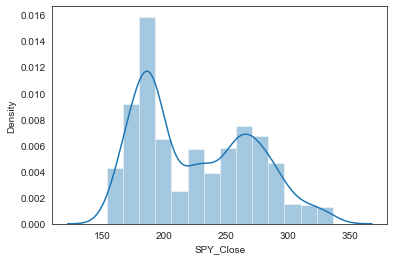

In [14]:
# Calculate Kurtosis and Skewness 
sns.distplot(data5.SPY_Close);
print( 'Kurtosis of normal distribution: {}'.format(stats.kurtosis(data5.SPY_Close)))
print( 'Skewness of normal distribution: {}'.format(stats.skew(data5.SPY_Close)))

In [15]:
plt.figure(figsize=(14,6))
plt.subplot(1,2,1)
data5['SPY_Close'].hist(bins=50)
plt.title('SPY_Close Distribution')
plt.subplot(1,2,2)
stats.probplot(data5['SPY_Close'], plot=plt);
data5.describe().T

NameError: name 'plt' is not defined

# Resample Data by Week, Quarter, Year

In [ ]:
data5.index = pd.to_datetime(data5.index)

# Code Needs to be fixed 
fig = plt.figure(figsize=(18,16))
fig.subplots_adjust(hspace=.4)
ax1 = fig.add_subplot(5,1,1)
ax1.plot(data5['SPY_Close'].resample('D').mean(),linewidth=1)
ax1.set_title('SPY Close resampled over day')
ax1.tick_params(axis='both', which='major')

ax2 = fig.add_subplot(5,1,2, sharex=ax1)
ax2.plot(data5['SPY_Close'].resample('W').mean(),linewidth=1)
ax2.set_title('SPY Close resampled over week')
ax2.tick_params(axis='both', which='major')

ax3 = fig.add_subplot(5,1,3, sharex=ax1)
ax3.plot(data5['SPY_Close'].resample('M').mean(),linewidth=1)
ax3.set_title('SPY Close over month')
ax3.tick_params(axis='both', which='major')

ax4  = fig.add_subplot(5,1,4, sharex=ax1)
ax4.plot(data5['SPY_Close'].resample('Q').mean(),linewidth=1)
ax4.set_title('SPY Close resampled over quarter')
ax4.tick_params(axis='both', which='major')

ax5  = fig.add_subplot(5,1,5, sharex=ax1)
ax5.plot(data5['SPY_Close'].resample('A').mean(),linewidth=1)
ax5.set_title('SPY Close resampled over year')
ax5.tick_params(axis='both', which='major');
print("The Time Series Shows an upward trend in general")

# Dicky Fuller Test
Null Hypothesis (H0): It suggests the time series has a unit root, meaning it is non-stationary. It has some time dependent structure.

Alternate Hypothesis (H1): It suggests the time series does not have a unit root, meaning it is stationary. It does not have time-dependent structure.

p-value > 0.05: Accept the null hypothesis (H0), the data has a unit root and is non-stationary.

p-value <= 0.05: Reject the null hypothesis (H0), the data does not have a unit root and is stationary.

In [ ]:
new_df=data5.resample('D', how=np.mean)

def test_stationarity(timeseries):
    rolmean = timeseries.rolling(window=30).mean()
    rolstd = timeseries.rolling(window=30).std()
    
    plt.figure(figsize=(14,5))
    sns.despine(left=True)
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')

    plt.legend(loc='best'); plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    
    print ('<Results of Dickey-Fuller Test>')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4],
                         index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)
test_stationarity(new_df.SPY_Close.dropna())

In [16]:
X_test.shape

NameError: name 'X_test' is not defined

In [17]:
train_predict.shape

NameError: name 'train_predict' is not defined